# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.152315 -0.008257  0.124823 -0.438372 -0.115707 -0.225058   
      201547 -0.429644 -0.180829  0.091231  0.321699  0.151782  0.138723   
      201548 -0.161068  0.576082 -0.436528  0.165498  0.241237  0.042973   
      201549 -0.260170  0.167611 -0.410230  0.064991  0.048733  0.131852   
      201550  0.441330  0.225024 -0.081751 -0.672187  0.065666 -0.758178   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.473106 -0.368344 -0.407803  0.184894  ... -0.078890  0.103824   
      201547 -0.128355 -0.300411  0.658483 -0.437008  ...  0.314439  0.368487   
      201548  0.055301 -0.306384 -0.244395  0.053250  ...  0.455030 -0.227580   
      201549 -0.398770 -0.091087  0.217093 -0.104882  ... -0.287345  0.278916   
      201550  0.085061 -0.633349  0.213285  0.176507  ...  0.162102 -0.204953   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.726407 -0.460573 -0.098291 -0.444475  0.310875  0.038217   
      201547  0.963722  0.200345 -0.157422 -0.599799 -0.170341 -0.038084   
      201548 -0.136099 -0.016585  0.391008  0.751067  0.211474  0.286467   
      201549  0.106186  0.005580  0.201473 -0.214119  0.614926 -0.359967   
      201550  0.413980 -0.400370 -0.097594 -0.198839 -0.752909 -0.144777   

                  1023    Labels  
41001 201546  0.056886 -0.861740  
      201547 -0.595335 -0.854589  
      201548 -0.406842 -0.856973  
      201549  0.149468 -0.856973  
      201550  0.328874 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4         5  \
5360 201546  0.186118 -0.467990  0.435267  0.347558  0.223379 -0.092600   
     201547 -0.031743  0.128215 -0.254998  0.266815 -0.474168 -0.156857   
     201548 -0.109709  0.166347 -0.013395 -0.174514 -0.390162 -0.349858   
     201549  0.359992  0.546292  0.127535 -0.222885 -0.547900 -0.011747   
     201550  0.137245 -0.345681 -0.045487 -0.131272 -0.013486  0.008818   

                    6         7         8         9  ...      1015      1016  \
5360 201546  0.222575 -0.090122 -0.288593  0.422614  ...  0.060105  0.443189   
     201547 -0.358710 -0.129209 -0.221991  0.871192  ... -0.279091  0.047074   
     201548 -0.130038 -0.177032  0.483901  0.582196  ...  0.597011  0.044982   
     201549 -0.106706  0.215504  0.036656  0.341239  ... -0.498720 -0.400292   
     201550  0.253216 -0.028422 -0.046990 -0.039587  ...  0.253952  0.262296   

                 1017      1018      1019      1020      1021      1022  \
5360 201546  0.036510 -0.045586 -0.175214 -0.099030 -0.193360 -0.066682   
     201547  0.327831  0.101820 -0.175938  0.752862  0.237860 -0.738861   
     201548  0.273295 -0.035685 -0.085753 -0.327600  0.082075 -0.375873   
     201549  0.091562  0.163436 -0.452942  0.085359 -0.203362 -0.128735   
     201550 -0.078173 -0.191487  0.303004 -0.286701 -0.399233 -0.221834   

                 1023    Labels  
5360 201546 -0.025980 -0.990465  
     201547 -0.068780 -0.969011  
     201548  0.414215 -0.995232  
     201549 -0.053798 -0.997616  
     201550 -0.209901 -0.971395  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 1024)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 1024)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

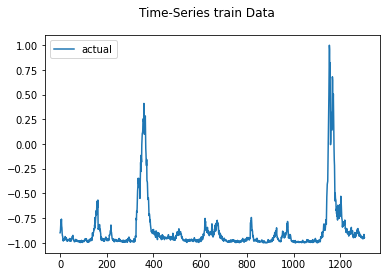

2023-03-06 16:29:08.734173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 16:29:08.734238: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 16:29:08.734265: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 16:29:08.734625: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 16:29:08.836358: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 52.490
Test RMSE: 65.608
Test sMAPE: 140.139
Test R Squared: -2.962
{'mae': 52.490453217658526, 'rmse': 65.60803993470451, 'smape': 140.13944714610867, 'r2': -2.961872934396611}


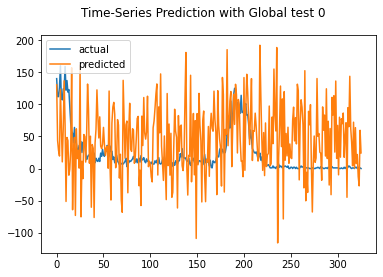

Test MAE: 44.537
Test RMSE: 53.358
Test sMAPE: 125.156
Test R Squared: -1.620
{'mae': 44.537089322973614, 'rmse': 53.357907781199245, 'smape': 125.15628992349525, 'r2': -1.6204990127709133}


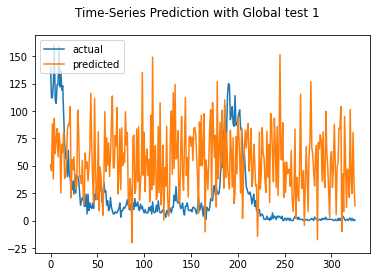

Test MAE: 45.489
Test RMSE: 53.304
Test sMAPE: 126.275
Test R Squared: -1.615
{'mae': 45.489129258628274, 'rmse': 53.304453834339355, 'smape': 126.2750075287857, 'r2': -1.615251211396091}


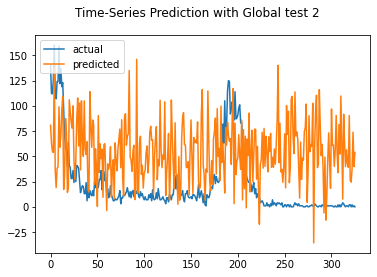

Test MAE: 76.566
Test RMSE: 83.588
Test sMAPE: 142.541
Test R Squared: -5.431
{'mae': 76.566371291693, 'rmse': 83.58840316530357, 'smape': 142.540708420981, 'r2': -5.430999468750969}


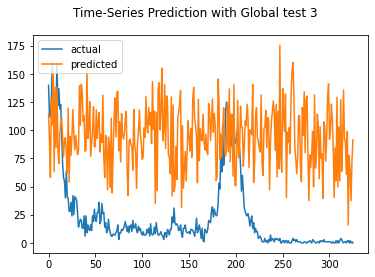

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 50.229
Test RMSE: 62.392
Test sMAPE: 144.270
Test R Squared: -2.583
{'mae': 50.228507860489415, 'rmse': 62.39171392207486, 'smape': 144.26968530991243, 'r2': -2.582945879973877}


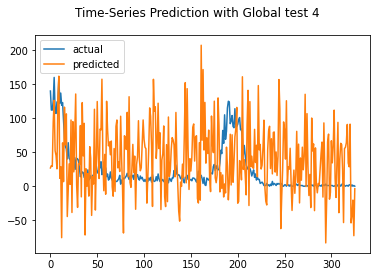

Test MAE: 70.630
Test RMSE: 81.163
Test sMAPE: 142.472
Test R Squared: -5.063
{'mae': 70.63028144598738, 'rmse': 81.16331027912697, 'smape': 142.47196905574134, 'r2': -5.063256198449005}


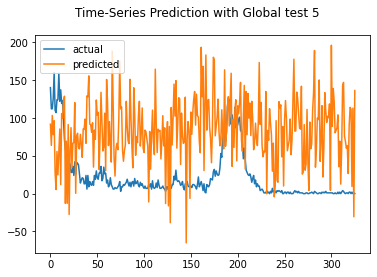

Test MAE: 41.472
Test RMSE: 51.844
Test sMAPE: 136.087
Test R Squared: -1.474
{'mae': 41.472079742357046, 'rmse': 51.84351294510038, 'smape': 136.08732879963094, 'r2': -1.4738608059395344}


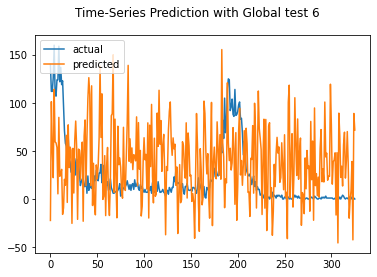

Test MAE: 61.822
Test RMSE: 70.992
Test sMAPE: 139.606
Test R Squared: -3.639
{'mae': 61.82216181930589, 'rmse': 70.99215999269995, 'smape': 139.60577363023748, 'r2': -3.6388165343698233}


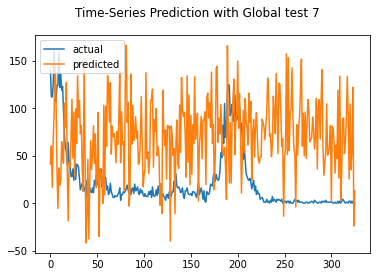

Test MAE: 64.057
Test RMSE: 72.781
Test sMAPE: 137.737
Test R Squared: -3.876
{'mae': 64.05693510449005, 'rmse': 72.780842686927, 'smape': 137.73727601693398, 'r2': -3.8755158838571395}


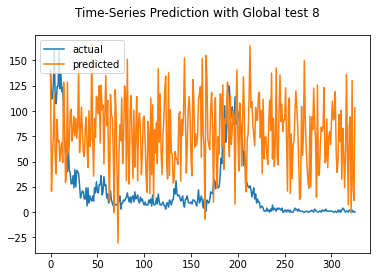

Test MAE: 60.142
Test RMSE: 69.327
Test sMAPE: 133.946
Test R Squared: -3.424
{'mae': 60.14192149097934, 'rmse': 69.32668911377183, 'smape': 133.94616382444312, 'r2': -3.423716998374611}


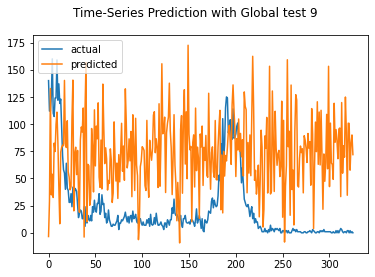

Test MAE: 55.225
Test RMSE: 62.806
Test sMAPE: 134.504
Test R Squared: -2.631
{'mae': 55.224683160430814, 'rmse': 62.80617457649099, 'smape': 134.504113727281, 'r2': -2.630706145105949}


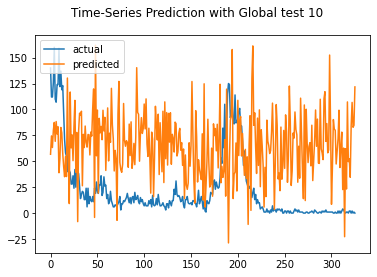

Test MAE: 65.958
Test RMSE: 72.718
Test sMAPE: 138.219
Test R Squared: -3.867
{'mae': 65.95790251924947, 'rmse': 72.71766534146509, 'smape': 138.2192871162077, 'r2': -3.86705518319042}


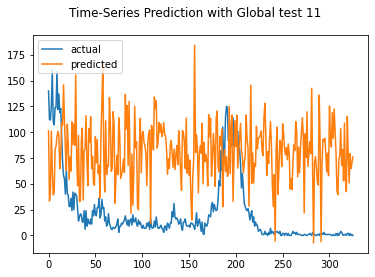

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 60.716
Test RMSE: 73.456
Test sMAPE: 141.603
Test R Squared: -3.966
{'mae': 60.71551321108648, 'rmse': 73.45611049574944, 'smape': 141.6032889718213, 'r2': -3.966406614146435}


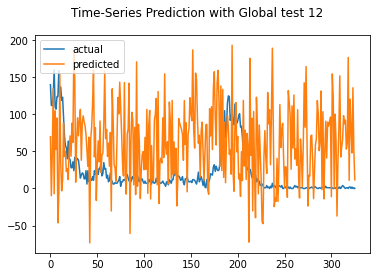

Test MAE: 46.390
Test RMSE: 54.828
Test sMAPE: 128.926
Test R Squared: -1.767
{'mae': 46.39043507866698, 'rmse': 54.82785230963546, 'smape': 128.92586208060249, 'r2': -1.766870829396383}


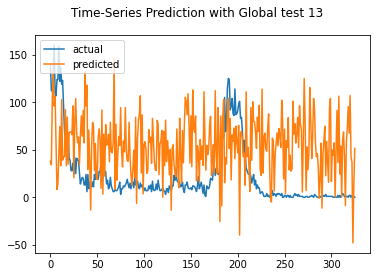

Test MAE: 56.587
Test RMSE: 65.464
Test sMAPE: 134.261
Test R Squared: -2.944
{'mae': 56.58714017381698, 'rmse': 65.46390155859456, 'smape': 134.26082452363403, 'r2': -2.944483887707378}


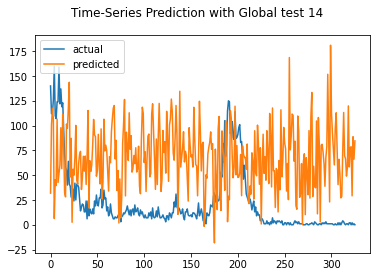

Test MAE: 69.304
Test RMSE: 79.794
Test sMAPE: 140.701
Test R Squared: -4.860
{'mae': 69.30354397154294, 'rmse': 79.79358953299156, 'smape': 140.70088768146957, 'r2': -4.860334705689059}


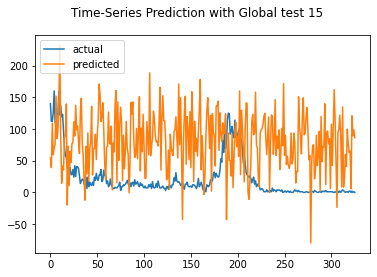

Test MAE: 52.915
Test RMSE: 62.087
Test sMAPE: 130.174
Test R Squared: -2.548
{'mae': 52.91458560343535, 'rmse': 62.087170543104456, 'smape': 130.17385792628812, 'r2': -2.5480534459572004}


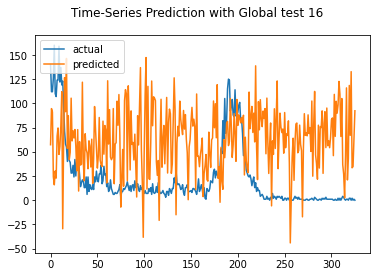

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 51.090
Test RMSE: 62.895
Test sMAPE: 134.233
Test R Squared: -2.641
{'mae': 51.090107921625204, 'rmse': 62.89548739499199, 'smape': 134.23279636542935, 'r2': -2.6410394972779185}


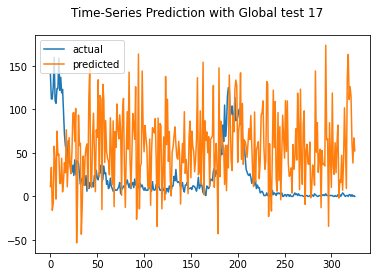

Test MAE: 53.153
Test RMSE: 64.716
Test sMAPE: 133.021
Test R Squared: -2.855
{'mae': 53.15275925288171, 'rmse': 64.71628241451805, 'smape': 133.02088609567383, 'r2': -2.854903753062916}


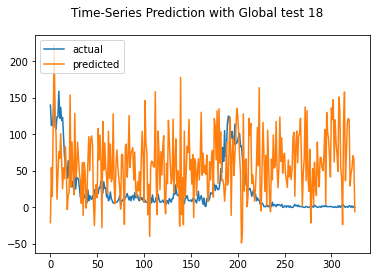

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 52.322
Test RMSE: 65.272
Test sMAPE: 149.757
Test R Squared: -2.921
{'mae': 52.321902793243616, 'rmse': 65.2720492389983, 'smape': 149.75665894590932, 'r2': -2.921397897859639}


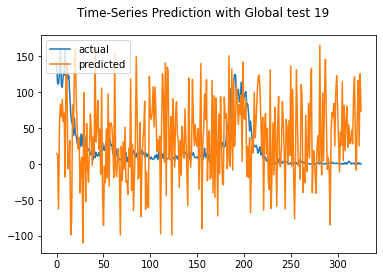

Test MAE: 69.606
Test RMSE: 79.639
Test sMAPE: 138.353
Test R Squared: -4.838
{'mae': 69.60649930626337, 'rmse': 79.63870798295227, 'smape': 138.35298144968996, 'r2': -4.837606643598313}


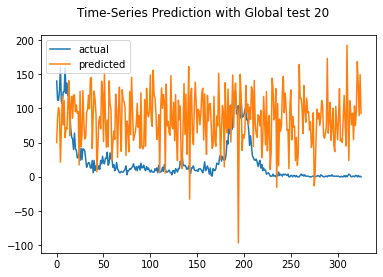

Test MAE: 52.207
Test RMSE: 60.912
Test sMAPE: 131.742
Test R Squared: -2.415
{'mae': 52.20724630593522, 'rmse': 60.91218180666947, 'smape': 131.74213463073005, 'r2': -2.415031607951566}


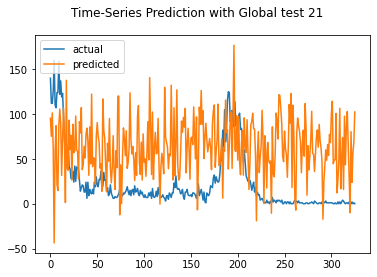

Test MAE: 48.311
Test RMSE: 56.131
Test sMAPE: 132.782
Test R Squared: -1.900
{'mae': 48.31107975734523, 'rmse': 56.13078407676457, 'smape': 132.7820141704767, 'r2': -1.8999374721836717}


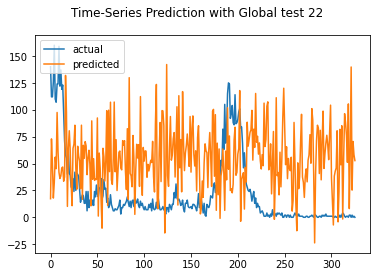

Test MAE: 66.482
Test RMSE: 78.276
Test sMAPE: 141.117
Test R Squared: -4.640
{'mae': 66.48199074674238, 'rmse': 78.27635315317113, 'smape': 141.11727130815532, 'r2': -4.639590679444227}


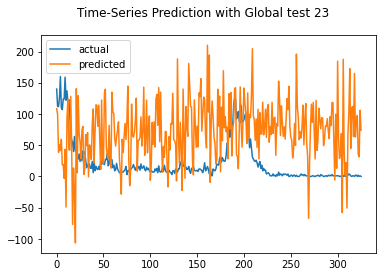

Test MAE: 59.735
Test RMSE: 68.842
Test sMAPE: 137.054
Test R Squared: -3.362
{'mae': 59.7350261054156, 'rmse': 68.84241774815943, 'smape': 137.05364115592084, 'r2': -3.3621304085497172}


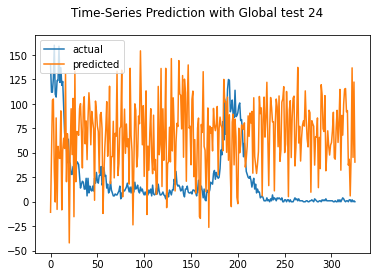

Test MAE: 64.149
Test RMSE: 71.861
Test sMAPE: 136.667
Test R Squared: -3.753
{'mae': 64.14927485969169, 'rmse': 71.8608099832093, 'smape': 136.66657874244373, 'r2': -3.753030841484687}


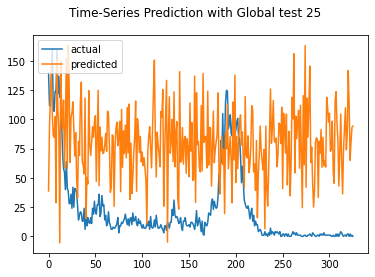

Test MAE: 78.858
Test RMSE: 87.281
Test sMAPE: 142.767
Test R Squared: -6.012
{'mae': 78.85822932998096, 'rmse': 87.28059603662518, 'smape': 142.76661417309958, 'r2': -6.011675729309499}


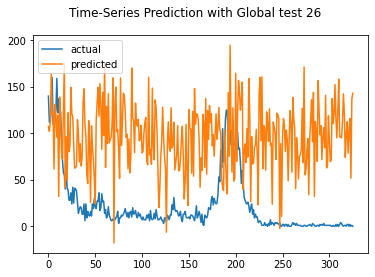

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 39.228
Test RMSE: 51.211
Test sMAPE: 141.238
Test R Squared: -1.414
{'mae': 39.22812371019937, 'rmse': 51.21127298121834, 'smape': 141.2376936565825, 'r2': -1.4138904639025713}


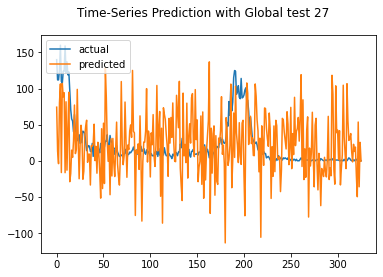

Test MAE: 69.316
Test RMSE: 76.727
Test sMAPE: 139.064
Test R Squared: -4.419
{'mae': 69.31618934101854, 'rmse': 76.72705961537062, 'smape': 139.06386256225446, 'r2': -4.418555507409673}


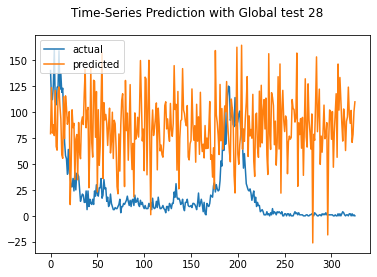

Test MAE: 73.781
Test RMSE: 85.887
Test sMAPE: 139.559
Test R Squared: -5.790
{'mae': 73.78126373722509, 'rmse': 85.8872519717615, 'smape': 139.55938684810826, 'r2': -5.789594400102643}


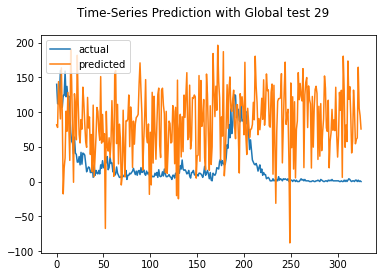

Test MAE: 55.205
Test RMSE: 64.150
Test sMAPE: 132.750
Test R Squared: -2.788
{'mae': 55.205069424550224, 'rmse': 64.14999325875847, 'smape': 132.7499221605633, 'r2': -2.7877355177147813}


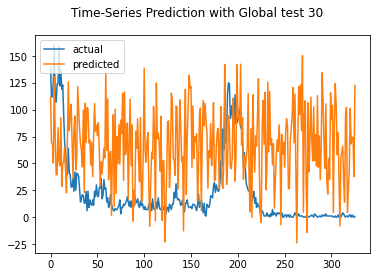

Test MAE: 54.485
Test RMSE: 64.502
Test sMAPE: 131.716
Test R Squared: -2.829
{'mae': 54.48454927301114, 'rmse': 64.50242406490644, 'smape': 131.71648168284446, 'r2': -2.8294683855859213}


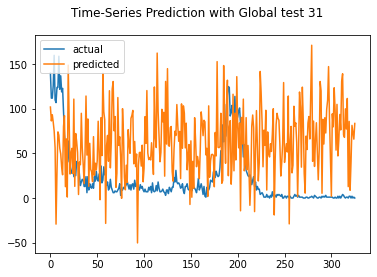

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 52.119
Test RMSE: 64.552
Test sMAPE: 145.745
Test R Squared: -2.835
{'mae': 52.11941976580152, 'rmse': 64.55181276105088, 'smape': 145.74507297688672, 'r2': -2.8353349824279652}


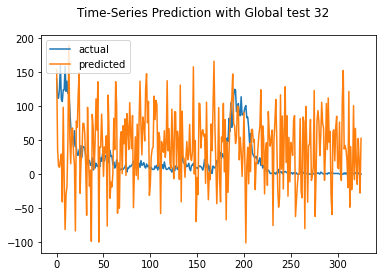

Test MAE: 54.411
Test RMSE: 62.332
Test sMAPE: 131.126
Test R Squared: -2.576
{'mae': 54.410737279734, 'rmse': 62.33234638500208, 'smape': 131.12606388468615, 'r2': -2.5761305688119607}


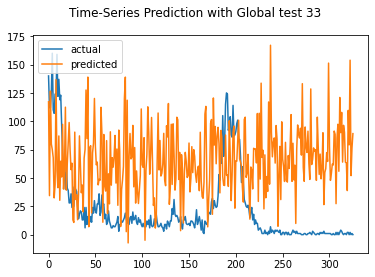

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 50.524
Test RMSE: 60.864
Test sMAPE: 137.132
Test R Squared: -2.410
{'mae': 50.52430665328459, 'rmse': 60.86377351889535, 'smape': 137.1318058236812, 'r2': -2.409605759202779}


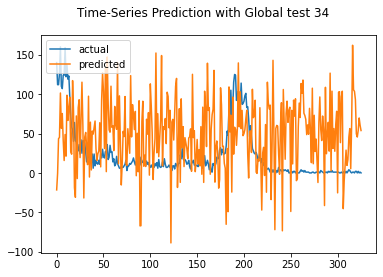

Test MAE: 92.095
Test RMSE: 100.058
Test sMAPE: 148.695
Test R Squared: -8.215
{'mae': 92.0953397341301, 'rmse': 100.05796734193464, 'smape': 148.6947361994534, 'r2': -8.214881787483014}


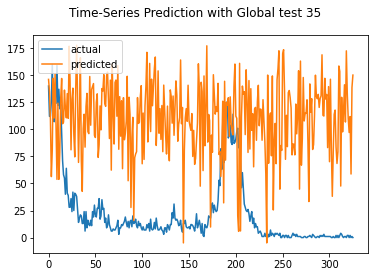

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 46.654
Test RMSE: 57.400
Test sMAPE: 140.410
Test R Squared: -2.033
{'mae': 46.65449655348538, 'rmse': 57.400150033521385, 'smape': 140.4100375451789, 'r2': -2.0325814306994228}


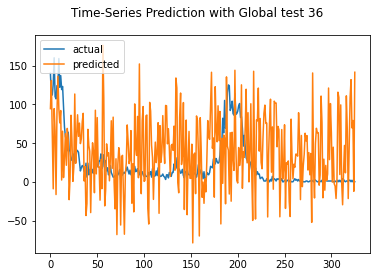

Test MAE: 71.936
Test RMSE: 80.559
Test sMAPE: 143.555
Test R Squared: -4.973
{'mae': 71.93647480943451, 'rmse': 80.55899467886094, 'smape': 143.55506321287916, 'r2': -4.973302267965789}


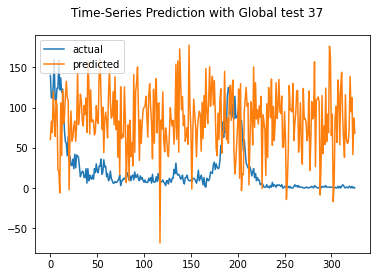

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 50.306
Test RMSE: 62.866
Test sMAPE: 138.502
Test R Squared: -2.638
{'mae': 50.30585724060521, 'rmse': 62.86627991055048, 'smape': 138.5018390533607, 'r2': -2.6376586215928914}


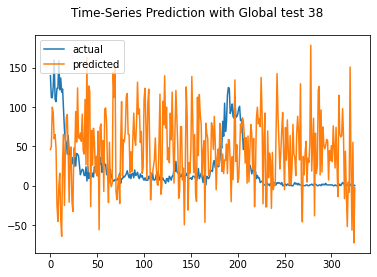

Test MAE: 48.995
Test RMSE: 57.553
Test sMAPE: 130.957
Test R Squared: -2.049
{'mae': 48.99514882531634, 'rmse': 57.553023156999764, 'smape': 130.95684893522144, 'r2': -2.0487562158047474}


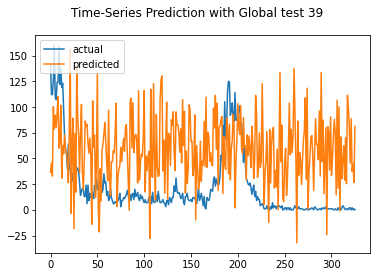

Test MAE: 57.563
Test RMSE: 65.436
Test sMAPE: 134.335
Test R Squared: -2.941
{'mae': 57.563178028065735, 'rmse': 65.43560751126604, 'smape': 134.33499735474788, 'r2': -2.9410749465122823}


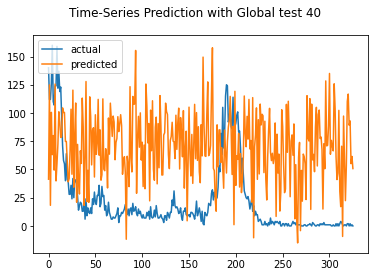

Test MAE: 50.147
Test RMSE: 58.050
Test sMAPE: 128.426
Test R Squared: -2.102
{'mae': 50.1470769811993, 'rmse': 58.05049553269975, 'smape': 128.42583593011761, 'r2': -2.1016892073377083}


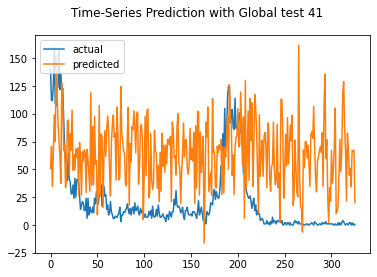

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 51.324
Test RMSE: 60.944
Test sMAPE: 138.046
Test R Squared: -2.419
{'mae': 51.32420248597678, 'rmse': 60.94357160215328, 'smape': 138.04590574995763, 'r2': -2.4185522424600148}


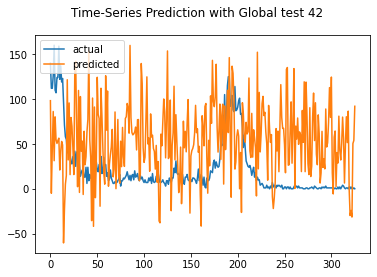

Test MAE: 72.607
Test RMSE: 82.060
Test sMAPE: 140.037
Test R Squared: -5.198
{'mae': 72.60715454231742, 'rmse': 82.05981374720795, 'smape': 140.03666691188258, 'r2': -5.197941460618985}


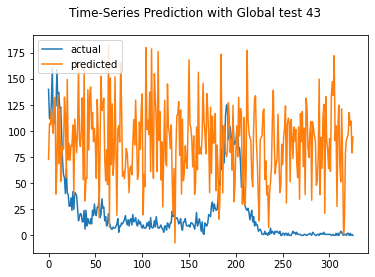

Test MAE: 52.221
Test RMSE: 60.040
Test sMAPE: 132.761
Test R Squared: -2.318
{'mae': 52.22066656102432, 'rmse': 60.039588415523106, 'smape': 132.7608440744228, 'r2': -2.3178888197243377}


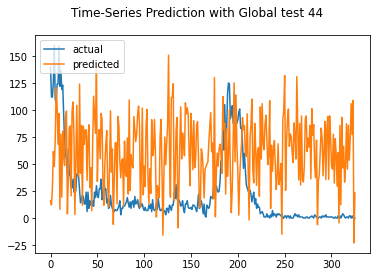

Test MAE: 58.552
Test RMSE: 66.923
Test sMAPE: 135.338
Test R Squared: -3.122
{'mae': 58.5515993658019, 'rmse': 66.9226086715424, 'smape': 135.3379419040165, 'r2': -3.1222292389477797}


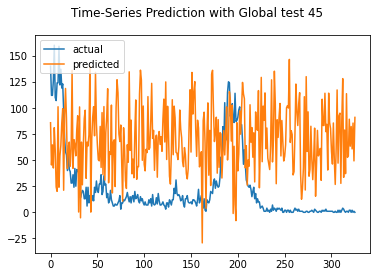

Test MAE: 55.864
Test RMSE: 64.096
Test sMAPE: 131.931
Test R Squared: -2.781
{'mae': 55.863821817139176, 'rmse': 64.09624135586999, 'smape': 131.93135988583853, 'r2': -2.7813906162421835}


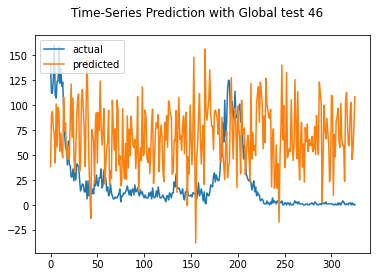

Test MAE: 44.305
Test RMSE: 54.164
Test sMAPE: 130.018
Test R Squared: -1.700
{'mae': 44.30520330086076, 'rmse': 54.1642885393417, 'smape': 130.01806413182325, 'r2': -1.7003030200002636}


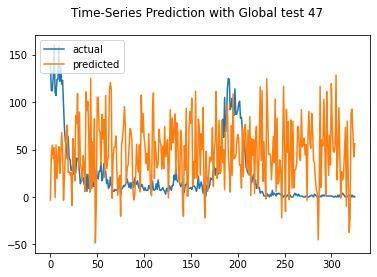

Test MAE: 55.612
Test RMSE: 62.257
Test sMAPE: 132.078
Test R Squared: -2.568
{'mae': 55.611557063149526, 'rmse': 62.2573674148961, 'smape': 132.07794777824805, 'r2': -2.567532358273819}


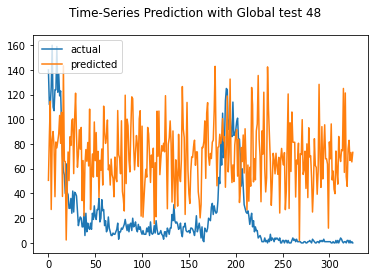

Test MAE: 66.418
Test RMSE: 75.558
Test sMAPE: 138.735
Test R Squared: -4.255
{'mae': 66.41833040959264, 'rmse': 75.55844895714122, 'smape': 138.73460211561766, 'r2': -4.254755152970903}


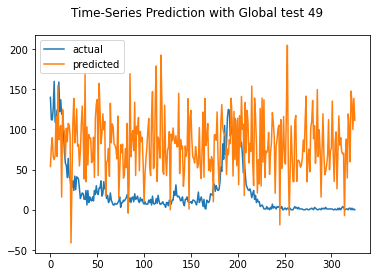

Test MAE: 45.651
Test RMSE: 53.994
Test sMAPE: 128.702
Test R Squared: -1.683
{'mae': 45.65128800748316, 'rmse': 53.994035990895426, 'smape': 128.70182630830476, 'r2': -1.6833541796575822}


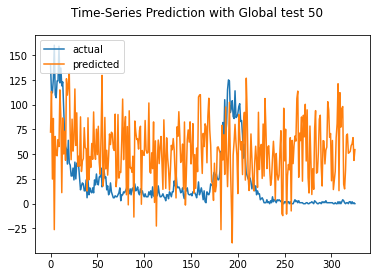

Test MAE: 68.910
Test RMSE: 75.978
Test sMAPE: 139.668
Test R Squared: -4.313
{'mae': 68.91028768738354, 'rmse': 75.97759278582838, 'smape': 139.66754315353234, 'r2': -4.313216044123669}


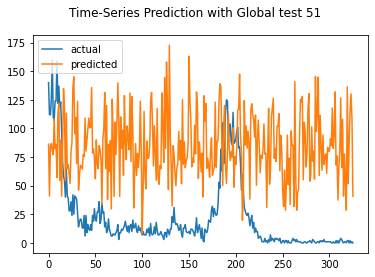

Test MAE: 75.859
Test RMSE: 83.082
Test sMAPE: 143.375
Test R Squared: -5.353
{'mae': 75.8588112314786, 'rmse': 83.08213609574592, 'smape': 143.37482337668453, 'r2': -5.353334542148028}


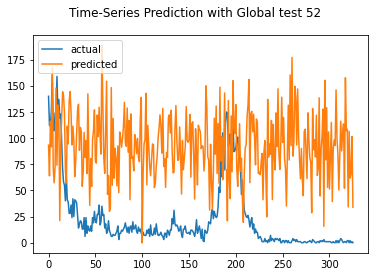

Test MAE: 52.303
Test RMSE: 59.548
Test sMAPE: 132.178
Test R Squared: -2.264
{'mae': 52.302889561726275, 'rmse': 59.54797707688144, 'smape': 132.17816646901704, 'r2': -2.2637767267607565}


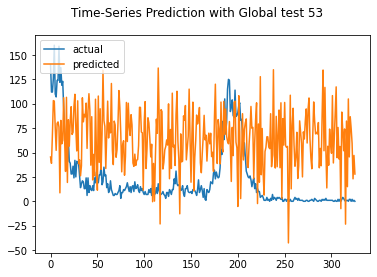

Test MAE: 52.673
Test RMSE: 61.669
Test sMAPE: 130.967
Test R Squared: -2.500
{'mae': 52.67324419694444, 'rmse': 61.66902688650623, 'smape': 130.96743915766103, 'r2': -2.500423631951014}


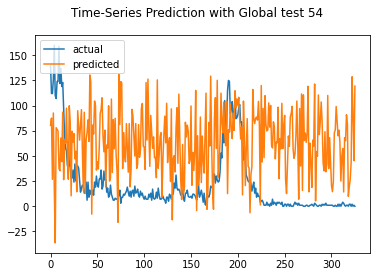

Test MAE: 63.047
Test RMSE: 75.229
Test sMAPE: 136.348
Test R Squared: -4.209
{'mae': 63.0473927409371, 'rmse': 75.22937837437357, 'smape': 136.34843655060908, 'r2': -4.209084022652093}


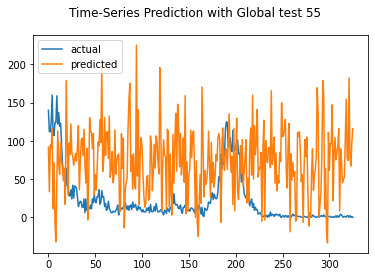

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 57.818
Test RMSE: 69.444
Test sMAPE: 137.545
Test R Squared: -3.439
{'mae': 57.81781157010172, 'rmse': 69.44394324377106, 'smape': 137.54476589521474, 'r2': -3.438693560493408}


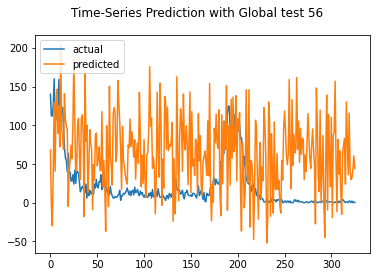

Test MAE: 45.661
Test RMSE: 53.834
Test sMAPE: 127.720
Test R Squared: -1.667
{'mae': 45.661044120788574, 'rmse': 53.83358812606115, 'smape': 127.7200691443276, 'r2': -1.6674302447250273}


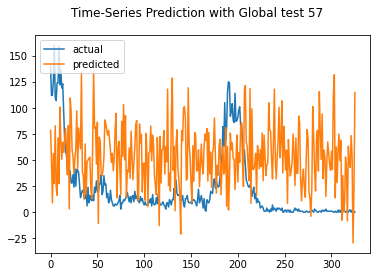

Test MAE: 64.058
Test RMSE: 71.577
Test sMAPE: 137.849
Test R Squared: -3.716
{'mae': 64.05772235020538, 'rmse': 71.57692481704234, 'smape': 137.84892429863845, 'r2': -3.7155514497205786}


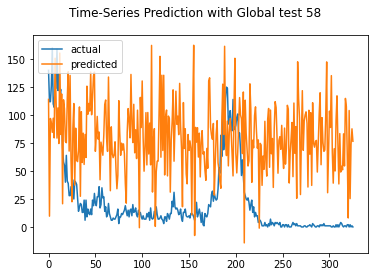

Test MAE: 59.825
Test RMSE: 68.263
Test sMAPE: 134.215
Test R Squared: -3.289
{'mae': 59.82508659545629, 'rmse': 68.26255463732262, 'smape': 134.21540416603256, 'r2': -3.288955008912522}


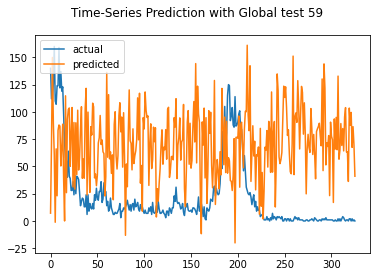

Test MAE: 66.807
Test RMSE: 74.986
Test sMAPE: 139.366
Test R Squared: -4.175
{'mae': 66.8074536542951, 'rmse': 74.98645825510043, 'smape': 139.36641627666708, 'r2': -4.17549745507351}


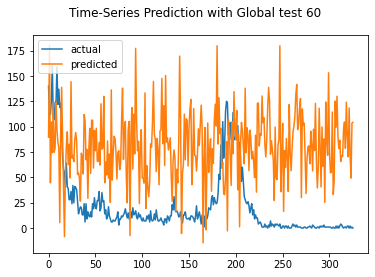

Test MAE: 70.212
Test RMSE: 77.027
Test sMAPE: 140.324
Test R Squared: -4.461
{'mae': 70.21164317511342, 'rmse': 77.02685241076283, 'smape': 140.32377784682774, 'r2': -4.4609816729744844}


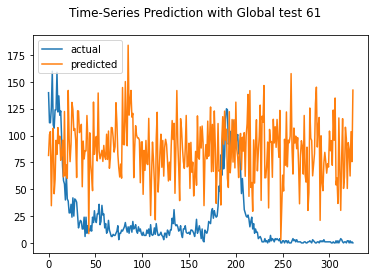

Test MAE: 67.030
Test RMSE: 75.432
Test sMAPE: 138.161
Test R Squared: -4.237
{'mae': 67.029860212759, 'rmse': 75.4320083821001, 'smape': 138.1608705532096, 'r2': -4.237183105045061}


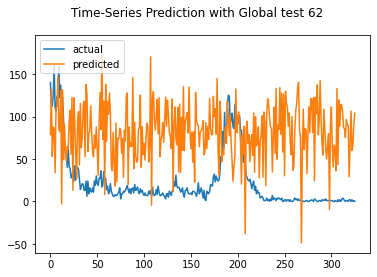

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 42.865
Test RMSE: 53.573
Test sMAPE: 142.370
Test R Squared: -1.642
{'mae': 42.865184409669574, 'rmse': 53.57289161066137, 'smape': 142.37044864189272, 'r2': -1.6416580072067184}


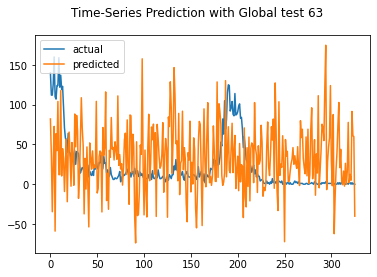

Test MAE: 43.246
Test RMSE: 51.995
Test sMAPE: 128.024
Test R Squared: -1.488
{'mae': 43.24555580528236, 'rmse': 51.99483828641125, 'smape': 128.0238680450661, 'r2': -1.4883237218789431}


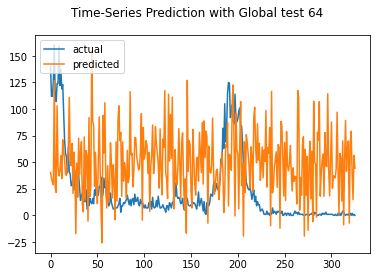

Test MAE: 44.810
Test RMSE: 54.580
Test sMAPE: 133.630
Test R Squared: -1.742
{'mae': 44.81029552276149, 'rmse': 54.57992196795599, 'smape': 133.62951169296008, 'r2': -1.74190394914632}


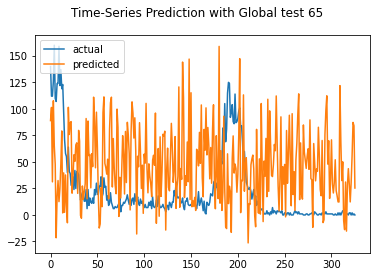

Test MAE: 54.561
Test RMSE: 63.729
Test sMAPE: 135.659
Test R Squared: -2.738
{'mae': 54.560831581339514, 'rmse': 63.72875187738718, 'smape': 135.6593480509923, 'r2': -2.738154457367579}


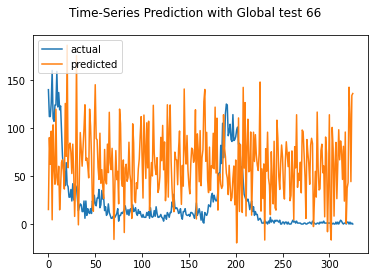

Test MAE: 48.898
Test RMSE: 59.657
Test sMAPE: 131.209
Test R Squared: -2.276
{'mae': 48.897947928656826, 'rmse': 59.65728105661493, 'smape': 131.2087711278881, 'r2': -2.2757694497824312}


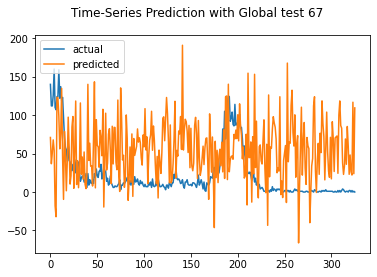

Test MAE: 65.967
Test RMSE: 73.155
Test sMAPE: 137.611
Test R Squared: -3.926
{'mae': 65.96735092759863, 'rmse': 73.15537137708783, 'smape': 137.611459271975, 'r2': -3.92582359786683}


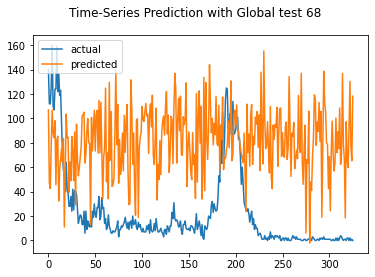

Test MAE: 52.364
Test RMSE: 59.919
Test sMAPE: 132.082
Test R Squared: -2.305
{'mae': 52.36380668615271, 'rmse': 59.91912229295607, 'smape': 132.08191406171548, 'r2': -2.3045878551249115}


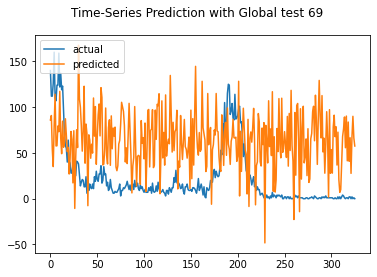

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 80.394
Test RMSE: 100.976
Test sMAPE: 178.109
Test R Squared: -8.385
{'mae': 80.39352679947403, 'rmse': 100.97636667952129, 'smape': 178.1091456999158, 'r2': -8.38481889174108}


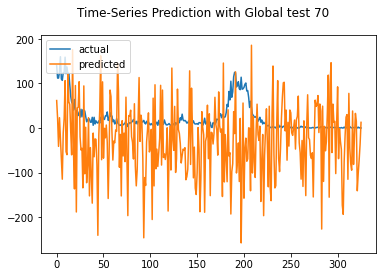

Test MAE: 61.656
Test RMSE: 69.823
Test sMAPE: 135.863
Test R Squared: -3.487
{'mae': 61.65620981696193, 'rmse': 69.8234363245296, 'smape': 135.86257453255982, 'r2': -3.48733872564231}


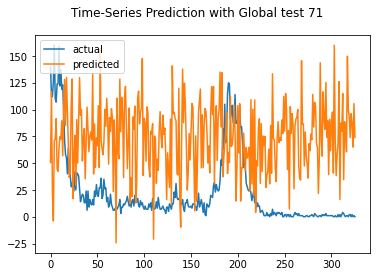

Test MAE: 56.689
Test RMSE: 63.927
Test sMAPE: 133.045
Test R Squared: -2.761
{'mae': 56.688964437121996, 'rmse': 63.92708087286795, 'smape': 133.0448691371733, 'r2': -2.761457535508665}


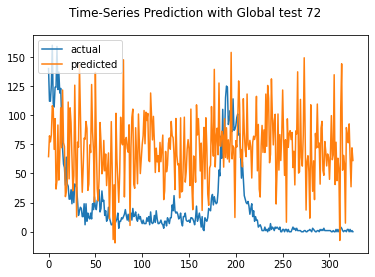

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 53.122
Test RMSE: 65.357
Test sMAPE: 135.630
Test R Squared: -2.932
{'mae': 53.122195002034395, 'rmse': 65.35694468462877, 'smape': 135.62964745073577, 'r2': -2.931605186375974}


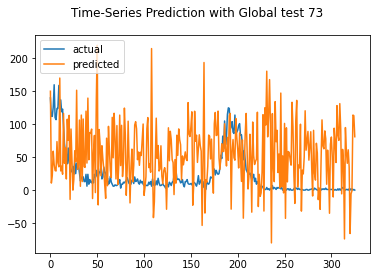

Test MAE: 61.240
Test RMSE: 70.393
Test sMAPE: 135.065
Test R Squared: -3.561
{'mae': 61.23973569511636, 'rmse': 70.39294409899718, 'smape': 135.06454309041226, 'r2': -3.5608383002038044}


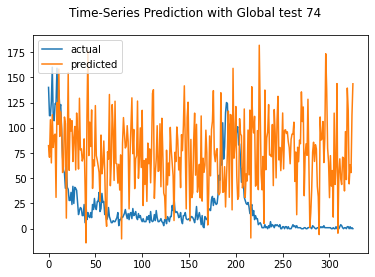

Test MAE: 59.861
Test RMSE: 68.686
Test sMAPE: 136.887
Test R Squared: -3.342
{'mae': 59.86143858301128, 'rmse': 68.68600116093843, 'smape': 136.88745296288786, 'r2': -3.34233056893385}


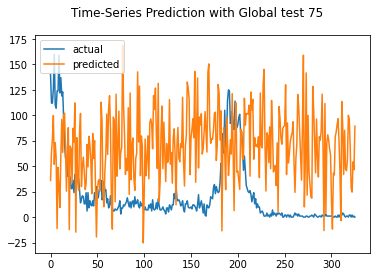

Test MAE: 57.613
Test RMSE: 68.904
Test sMAPE: 134.506
Test R Squared: -3.370
{'mae': 57.61304179802994, 'rmse': 68.90391671312949, 'smape': 134.50582854554332, 'r2': -3.369927529544743}


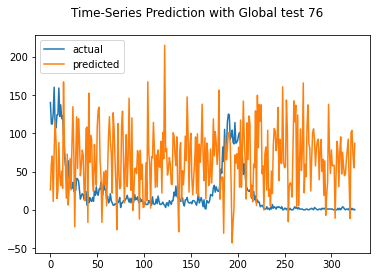

Test MAE: 61.644
Test RMSE: 70.247
Test sMAPE: 134.073
Test R Squared: -3.542
{'mae': 61.64395868120018, 'rmse': 70.24718739514353, 'smape': 134.07262172358574, 'r2': -3.541970371844192}


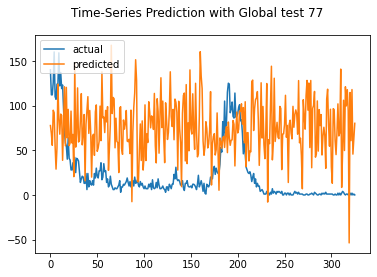

Test MAE: 62.855
Test RMSE: 70.533
Test sMAPE: 135.379
Test R Squared: -3.579
{'mae': 62.85479053105313, 'rmse': 70.53289611274795, 'smape': 135.37915508311946, 'r2': -3.5789916259539183}


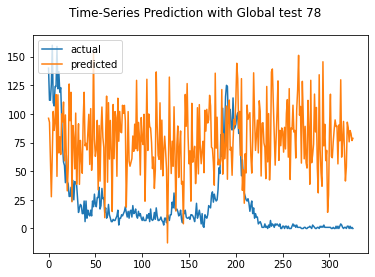

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 56.069
Test RMSE: 67.276
Test sMAPE: 141.124
Test R Squared: -3.166
{'mae': 56.069326276062455, 'rmse': 67.2758868316575, 'smape': 141.12417829920366, 'r2': -3.165865833769705}


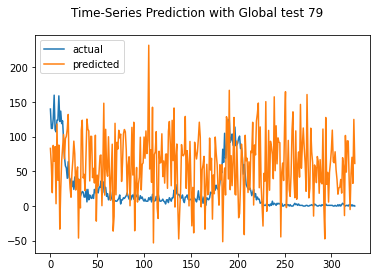

Test MAE: 57.605
Test RMSE: 65.205
Test sMAPE: 135.737
Test R Squared: -2.913
{'mae': 57.60504635555978, 'rmse': 65.20494048308052, 'smape': 135.737408924955, 'r2': -2.913338556845572}


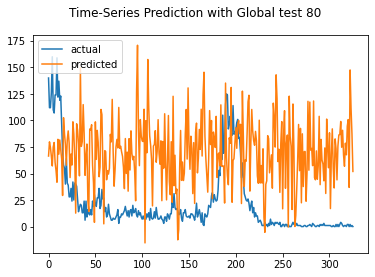

Test MAE: 49.674
Test RMSE: 58.727
Test sMAPE: 131.413
Test R Squared: -2.174
{'mae': 49.674044018142794, 'rmse': 58.72693564354501, 'smape': 131.4128951958966, 'r2': -2.1743959495971885}


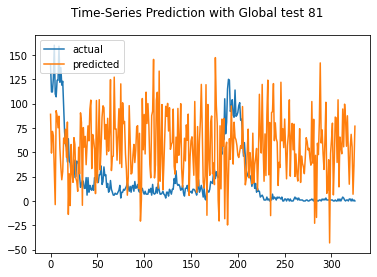

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 47.215
Test RMSE: 57.232
Test sMAPE: 137.919
Test R Squared: -2.015
{'mae': 47.215339048234235, 'rmse': 57.23154079412179, 'smape': 137.9188098089124, 'r2': -2.014791572604924}


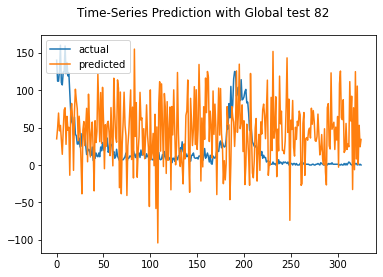

Test MAE: 51.199
Test RMSE: 59.709
Test sMAPE: 132.091
Test R Squared: -2.281
{'mae': 51.1992142929987, 'rmse': 59.708755198993586, 'smape': 132.09072384638654, 'r2': -2.2814247583793716}


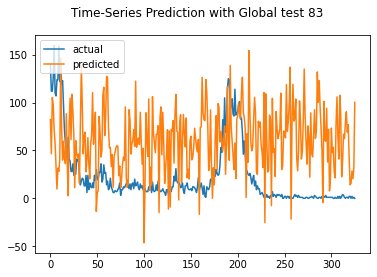

Test MAE: 65.428
Test RMSE: 73.341
Test sMAPE: 138.840
Test R Squared: -3.951
{'mae': 65.42830695111327, 'rmse': 73.34085636952133, 'smape': 138.8404850632953, 'r2': -3.9508340552879693}


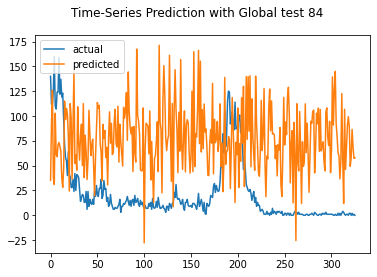

Test MAE: 56.751
Test RMSE: 65.420
Test sMAPE: 132.939
Test R Squared: -2.939
{'mae': 56.751174734413986, 'rmse': 65.41972879191472, 'smape': 132.93853497459136, 'r2': -2.939162482256017}


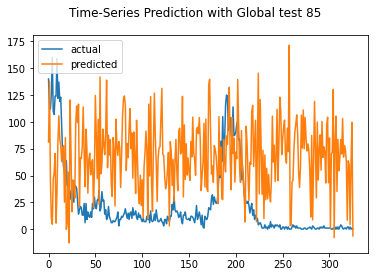

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 49.655
Test RMSE: 61.273
Test sMAPE: 137.244
Test R Squared: -2.456
{'mae': 49.65493907345219, 'rmse': 61.272550079788175, 'smape': 137.2438915841033, 'r2': -2.4555591164033337}


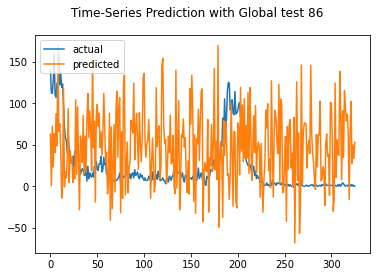

Test MAE: 45.564
Test RMSE: 52.622
Test sMAPE: 127.576
Test R Squared: -1.549
{'mae': 45.56376244941372, 'rmse': 52.62170731829197, 'smape': 127.57642282492607, 'r2': -1.5486857200142738}


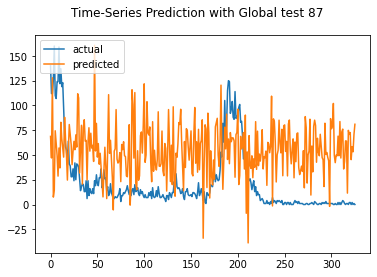

Test MAE: 74.220
Test RMSE: 83.719
Test sMAPE: 141.326
Test R Squared: -5.451
{'mae': 74.21950493926651, 'rmse': 83.71922150083896, 'smape': 141.32606569192387, 'r2': -5.451144630961208}


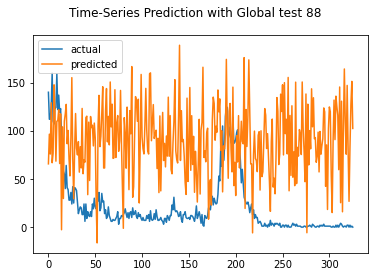

Test MAE: 50.785
Test RMSE: 59.512
Test sMAPE: 134.443
Test R Squared: -2.260
{'mae': 50.785204617889384, 'rmse': 59.51233119883093, 'smape': 134.44340827743974, 'r2': -2.2598704524646656}


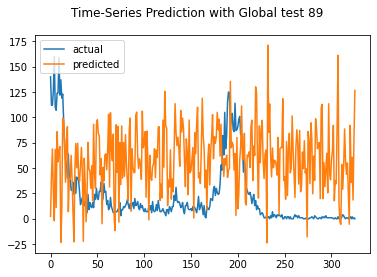

Test MAE: 74.864
Test RMSE: 82.746
Test sMAPE: 140.991
Test R Squared: -5.302
{'mae': 74.86411955184732, 'rmse': 82.74604806762775, 'smape': 140.9912677900189, 'r2': -5.302036852702221}


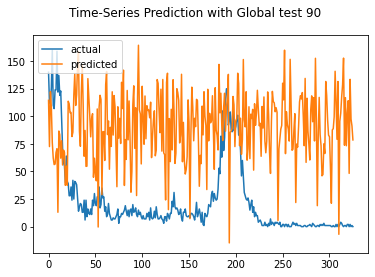

Test MAE: 63.475
Test RMSE: 71.663
Test sMAPE: 136.524
Test R Squared: -3.727
{'mae': 63.4751972318427, 'rmse': 71.6625542272608, 'smape': 136.52440924904676, 'r2': -3.726840881975672}


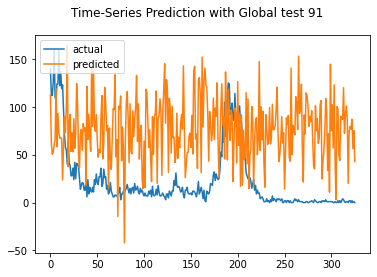

Test MAE: 58.871
Test RMSE: 68.706
Test sMAPE: 134.835
Test R Squared: -3.345
{'mae': 58.8711857291087, 'rmse': 68.70568777960783, 'smape': 134.83547570126296, 'r2': -3.3448201026225624}


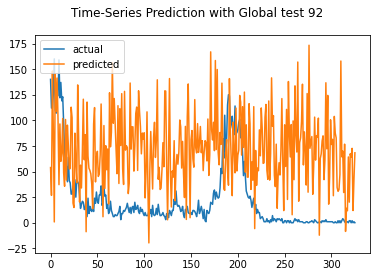

Test MAE: 82.424
Test RMSE: 91.152
Test sMAPE: 144.351
Test R Squared: -6.648
{'mae': 82.42360004471855, 'rmse': 91.15240370116149, 'smape': 144.3513343105171, 'r2': -6.647556025914879}


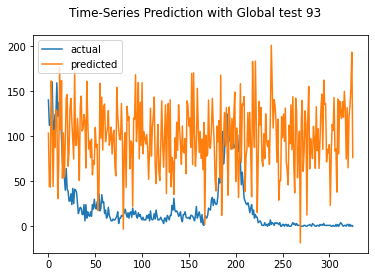

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 43.933
Test RMSE: 54.850
Test sMAPE: 139.330
Test R Squared: -1.769
{'mae': 43.9325964218634, 'rmse': 54.849989212198494, 'smape': 139.33003459603114, 'r2': -1.7691055445017758}


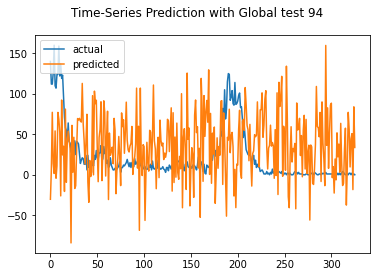

Test MAE: 51.235
Test RMSE: 57.929
Test sMAPE: 131.207
Test R Squared: -2.089
{'mae': 51.23491162537066, 'rmse': 57.92852282090702, 'smape': 131.20748997997106, 'r2': -2.0886686814827065}


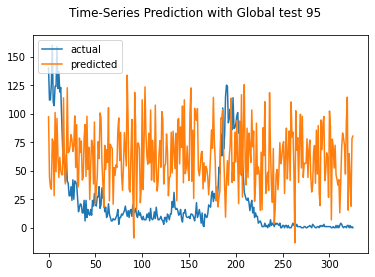

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 50.444
Test RMSE: 62.746
Test sMAPE: 145.103
Test R Squared: -2.624
{'mae': 50.44352393912757, 'rmse': 62.74550690125599, 'smape': 145.10271721931076, 'r2': -2.623695365689217}


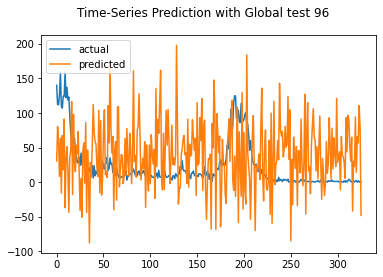

Test MAE: 53.426
Test RMSE: 64.023
Test sMAPE: 134.809
Test R Squared: -2.773
{'mae': 53.425842006513676, 'rmse': 64.02317998337443, 'smape': 134.80850060983053, 'r2': -2.7727749431681357}


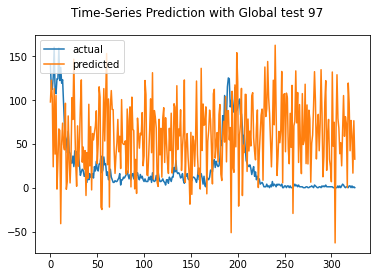

Test MAE: 57.531
Test RMSE: 65.957
Test sMAPE: 133.301
Test R Squared: -3.004
{'mae': 57.53149175205114, 'rmse': 65.95698275701619, 'smape': 133.30083754777274, 'r2': -3.004128228672358}


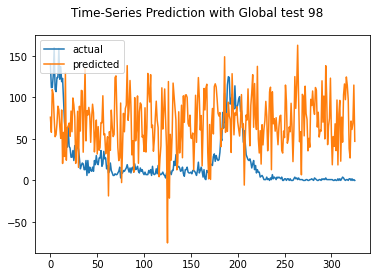

Test MAE: 42.777
Test RMSE: 50.467
Test sMAPE: 126.928
Test R Squared: -1.344
{'mae': 42.777141299532964, 'rmse': 50.466743544328104, 'smape': 126.92754207694765, 'r2': -1.3442125154293638}


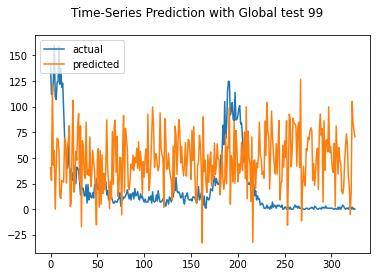

rmse : average=67.093, std=10.326
mae : average=57.749, std=10.254
smape : average=136.599, std=6.452
r2 : average=-3.241, std=1.364


([67.09315052075104, 10.325505530891418],
 [57.748974592235, 10.254355407142024],
 [136.59854384986969, 6.452408123271574],
 [-3.2413973693108913, 1.3643013740434353])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
